In [13]:
import pandas as pd
import psycopg2
import sqlalchemy
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_pickle('./pkls/has_mycotoxin.pkl')

<h5>Clean and flatten data from mycotoxin test results</h5>

In [4]:
df_mycotoxin_results = pd.DataFrame()
not_included = 0

for index, row in df.iterrows():
    
    # Check if type is dictionary, both formats (lists and dicts) will appear
    is_dict = type(row['coa_data']['mycotoxin_test']) is dict
    
    # Pull out mycotoxin test
    mycotoxin_test = row['coa_data']['mycotoxin_test']['results'] if is_dict else row['coa_data']['mycotoxin_test'][0]['results']
    
    if type(mycotoxin_test) is not dict:
        not_included += 1
        continue
        
    # Create temporary df from each row of mycotoxin results to merge with other rows of data
    # Only keep entry 'amount'
    temp_df = pd.DataFrame.from_dict(mycotoxin_test)
    temp_df = temp_df[temp_df.index == 'amount'].reset_index()
    
    df_mycotoxin_results = df_mycotoxin_results.append(temp_df, ignore_index = True)
    
print(not_included)
print(df_mycotoxin_results.head())

/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


0
  Aflatoxin B1 Aflatoxin B2 Aflatoxin G1 Aflatoxin G2 Aflatoxins Ochratoxin A  \
0            0            0            0            0          0            0   
1            0            0            0            0          0            0   
2            0            0            0            0          0            0   
3            0            0            0            0          0            0   
4            0            0            0            0          0            0   

    index  
0  amount  
1  amount  
2  amount  
3  amount  
4  amount  


In [5]:
df_mycotoxin_results.describe()

,Aflatoxin B1,Aflatoxin B2,Aflatoxin G1,Aflatoxin G2,Aflatoxins,Ochratoxin A,index
count,5406,5406,5406.0,5406,5379.0,5406,5406
unique,1,2,5.0,2,5.0,1,1
top,0,0,0.0,0,0.0,0,amount
freq,5406,5405,5402.0,5405,5375.0,5406,5406


<h5>Look at unique values in columns</h5>

In [6]:
for column in df_mycotoxin_results.columns:
    print(df_mycotoxin_results[column].unique())

[0]
[0 '< 0']
[0 0.69 0.39 0.37 0.3]
[0 '< 0']
[0 nan 0.69 0.39 0.37 0.3]
[0]
['amount']


In [7]:
for column in df_mycotoxin_results.columns:
    df_mycotoxin_results[column].replace('< 0', 0, inplace=True)
df_mycotoxin_results.describe()

,Aflatoxin B1,Aflatoxin B2,Aflatoxin G1,Aflatoxin G2,Aflatoxins,Ochratoxin A
count,5406.0,5406.0,5406.000000,5406.0,5379.000000,5406.0
mean,0.0,0.0,0.000324,0.0,0.000325,0.0
std,0.0,0.0,0.012574,0.0,0.012605,0.0
min,0.0,0.0,0.000000,0.0,0.000000,0.0
25%,0.0,0.0,0.000000,0.0,0.000000,0.0
50%,0.0,0.0,0.000000,0.0,0.000000,0.0
75%,0.0,0.0,0.000000,0.0,0.000000,0.0
max,0.0,0.0,0.690000,0.0,0.690000,0.0


<h5>Check general shape of original data</h5>

In [10]:
for index, row in df.iterrows():
    
    # Check if type is list
    is_list = type(row['coa_data']['mycotoxin_test']) is list
    
    # Look at length of results in list format
    if is_list:
        if (len(row['coa_data']['mycotoxin_test']) > 1):
            print(len(row['coa_data']['mycotoxin_test']))
            print(row['coa_data']['mycotoxin_test'][0]['results'])
            print(row['coa_data']['mycotoxin_test'][1]['results'])            

2
{'Aflatoxins': {'analyte': 'Aflatoxins', 'passed': True, 'amount': 0, 'units': 'µg/kg'}, 'Aflatoxin B2': {'analyte': 'Aflatoxin B2', 'passed': True, 'amount': 0, 'units': 'µg/kg'}, 'Aflatoxin G2': {'analyte': 'Aflatoxin G2', 'passed': True, 'amount': 0, 'units': 'µg/kg'}, 'Aflatoxin G1': {'analyte': 'Aflatoxin G1', 'passed': True, 'amount': 0, 'units': 'µg/kg'}, 'Ochratoxin A': {'analyte': 'Ochratoxin A', 'passed': True, 'amount': 0, 'units': 'µg/kg'}, 'Aflatoxin B1': {'analyte': 'Aflatoxin B1', 'passed': True, 'amount': 0, 'units': 'µg/kg'}}
{'Aflatoxins': {'analyte': 'Aflatoxins', 'passed': True, 'amount': 0, 'units': 'µg/kg'}, 'Aflatoxin B2': {'analyte': 'Aflatoxin B2', 'passed': True, 'amount': 0, 'units': 'µg/kg'}, 'Aflatoxin G2': {'analyte': 'Aflatoxin G2', 'passed': True, 'amount': 0, 'units': 'µg/kg'}, 'Aflatoxin G1': {'analyte': 'Aflatoxin G1', 'passed': True, 'amount': 0, 'units': 'µg/kg'}, 'Ochratoxin A': {'analyte': 'Ochratoxin A', 'passed': True, 'amount': 0, 'units': 'µ

<h2>Above results show us we are not including one result set that with two entries where all the measured analyte amounts are zero</h2>

In [11]:
df_mycotoxin_results.to_pickle('./pkls/cleaned_mycotoxin_results.pkl')

In [12]:
df_mycotoxin_results.drop_duplicates().describe()

,Aflatoxin B1,Aflatoxin B2,Aflatoxin G1,Aflatoxin G2,Aflatoxins,Ochratoxin A
count,6.0,6.0,6.000000,6.0,5.000000,6.0
mean,0.0,0.0,0.291667,0.0,0.350000,0.0
std,0.0,0.0,0.262558,0.0,0.246272,0.0
min,0.0,0.0,0.000000,0.0,0.000000,0.0
25%,0.0,0.0,0.075000,0.0,0.300000,0.0
50%,0.0,0.0,0.335000,0.0,0.370000,0.0
75%,0.0,0.0,0.385000,0.0,0.390000,0.0
max,0.0,0.0,0.690000,0.0,0.690000,0.0


In [14]:
df_mycotoxin_results = pd.read_pickle('./pkls/cleaned_mycotoxin_results.pkl')

In [15]:
correlations = df_mycotoxin_results.corr()

In [16]:
print(correlations)

              Aflatoxin B1  Aflatoxin B2  Aflatoxin G1  Aflatoxin G2  \
Aflatoxin B1           NaN           NaN           NaN           NaN   
Aflatoxin B2           NaN           NaN           NaN           NaN   
Aflatoxin G1           NaN           NaN           1.0           NaN   
Aflatoxin G2           NaN           NaN           NaN           NaN   
Aflatoxins             NaN           NaN           1.0           NaN   
Ochratoxin A           NaN           NaN           NaN           NaN   

              Aflatoxins  Ochratoxin A  
Aflatoxin B1         NaN           NaN  
Aflatoxin B2         NaN           NaN  
Aflatoxin G1         1.0           NaN  
Aflatoxin G2         NaN           NaN  
Aflatoxins           1.0           NaN  
Ochratoxin A         NaN           NaN  


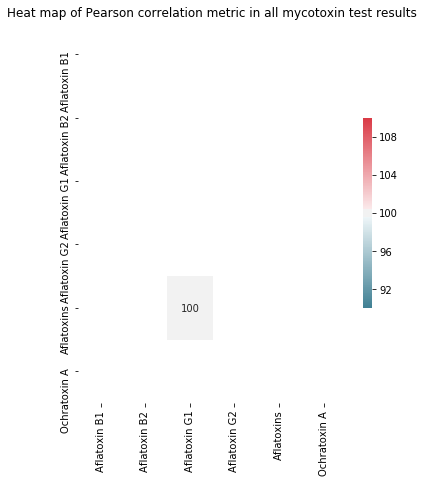

In [17]:
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(6, 7))
plt.title('Heat map of Pearson correlation metric in all mycotoxin test results')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr_heat = sns.heatmap(correlations * 100, annot=True, fmt='.0f', mask=mask, cmap=cmap, cbar_kws={"shrink": .5})